In [732]:
# import libraries 
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [1042]:
# input receiver's location from csv file 
csv_rec_in = np.loadtxt('/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/receiver.csv', delimiter=',')
rec_x = csv_rec_in[0]
rec_y = csv_rec_in[1]
rec_z = csv_rec_in[2]

# input grid's location from csv file 
csv_grid_in = np.loadtxt('/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/grid.csv', delimiter=',')
grid_x = csv_grid_in[0]
grid_y = csv_grid_in[1]
grid_z = csv_grid_in[2]

Observation equation of the wave amplitude for a given location as follows,

$$
{u^{obs}} = {G}{m}
$$

where,

$$
{u^{obs}} = 
\begin{pmatrix} u^{obs}(x_{S1},y_{S1};t) \\ u^{obs}(x_{S1},y_{S1};t) \\ \vdots \\ u^{obs}(x_{SN},y_{SN};t) \end{pmatrix}
$$

$$
{G} = 
\begin{pmatrix} 1 & x_{S1},x_{G} & x_{S1},x_{G} \\ 1 & x_{S2},x_{G} & x_{S2},x_{G} \\ & \vdots & \\ 1 & x_{SN},x_{G} & x_{SN},x_{G}
\end{pmatrix}
$$

$$
{m} = 
\begin{pmatrix} u(x_G,y_G;t) \\ \partial_x u(x_G,y_G;t) \\ \partial_y u(x_G,y_G;t) \end{pmatrix}
$$

The wave amplitude and its spatial gradients can be estimated by using the least square method if we have input data from three or more stations. We note that we can significantly reduce the computational cost by using a previously computed Kernel matrix ($\boldsymbol{K}$) for the least squares calculation because this inverse problem depends only on the station layout,

$$
m = ({G^{T}}{W}{G})^{-1}{G^{T}}{W}{u^{obs}} = {K}{u^{obs}}
$$

It can be decomposed as follows,

$$
m = 
\begin{pmatrix} u(x_G,y_G;t) \\ \partial_x u(x_G,y_G;t) \\ \partial_y u(x_G,y_G;t) \end{pmatrix} =
\begin{pmatrix} k_u . u^{obs} \\ k_{\partial x} . u^{obs} \\ k_{\partial y} . u^{obs} \end{pmatrix}
$$

In [1054]:
# build grid system matrix G
G = np.zeros((3,rec_x.size,grid_x.size))
recx = np.tile(rec_x,(grid_x.size,1)).T
recy = np.tile(rec_y,(grid_x.size,1)).T
gridx = np.tile(grid_x,(rec_x.size,1))
gridy = np.tile(grid_y,(rec_x.size,1))
G[0] = np.ones((grid_x.size))
G[1] = recx - gridx
G[2] = recy - gridy

# compute the distance between grids and stations 
d = np.zeros((1,rec_x.size,grid_x.size))
d[0] = np.sqrt(G[1]**2 + G[2]**2)

# transpose to make it fortran-like array
G = G.T 

We empirically adopted the Gaussian function with variance ($\sigma$) and cutoff distance, which smoothly decreases weight amplitude with distance between the target grid point and the station.

<IPython.core.display.Javascript object>


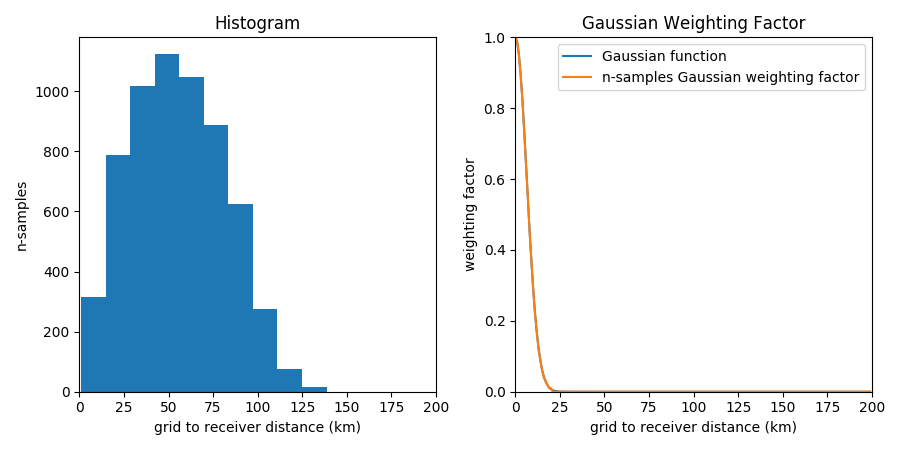

In [1129]:
# define Gaussian weighting factor 
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

cutoff_distance = 8 # in km
mu  = 0 
sigma = (cutoff_distance*4)/1000
gaus = gaussian(np.linspace(0, 1, 200), mu, sigma)
gausf = np.around(gaus,2) # round up to 2 decimal

# plot distance distribution histogram 
fig = plt.figure(figsize=(9,4.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(d.flatten(), bins=10)
ax1.set_title('Histogram')
ax1.set_xlabel('grid to receiver distance (km)')
ax1.set_ylabel('n-samples')
ax1.set_xlim(0,200)

ax2.plot(gaus, label='Gaussian function')
ax2.plot(gausf, label='n-samples Gaussian weighting factor')
ax2.set_xlim(0,200)
ax2.set_ylim(0,1)
ax2.set_title('Gaussian Weighting Factor')
ax2.set_xlabel('grid to receiver distance (km)')
ax2.set_ylabel('weighting factor')
ax2.legend()

plt.tight_layout()
plt.show()

In [1130]:
# get weighting factor from distance between grid and station
df = (np.around(d,0)).astype(int)  # round up the station distance and make it integer 
weight_df = (gausf[df]).T          # convert distance to weighting factor

# build diagonal weight matrix W
W = np.identity(rec_x.size) * weight_df

# calculate kernel matrix K
K = np.zeros((grid_x.size,3,rec_x.size)) # initialize K dimension
for i in range(0,grid_x.size):
    K[i] = inv(G[i].T @ W[i] @ G[i]) @ G[i].T @ W[i]

In [1086]:
# get receiver data every time steps 
import pyasdf
seisrec  = pyasdf.ASDFDataSet("/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/seismogram_receiver.h5")

# displacement
uX_obs = np.stack(waveforms.displacement.select()[0].data for k, waveforms in enumerate(seisrec.waveforms))
uY_obs = np.stack(waveforms.displacement.select()[1].data for k, waveforms in enumerate(seisrec.waveforms))
uZ_obs = np.stack(waveforms.displacement.select()[2].data for k, waveforms in enumerate(seisrec.waveforms))

# velocity
vX_obs = np.stack(waveforms.velocity.select()[0].data for k, waveforms in enumerate(seisrec.waveforms))
vY_obs = np.stack(waveforms.velocity.select()[1].data for k, waveforms in enumerate(seisrec.waveforms))
vZ_obs = np.stack(waveforms.velocity.select()[2].data for k, waveforms in enumerate(seisrec.waveforms))

# acceleration
aX_obs = np.stack(waveforms.acceleration.select()[0].data for k, waveforms in enumerate(seisrec.waveforms))
aY_obs = np.stack(waveforms.acceleration.select()[1].data for k, waveforms in enumerate(seisrec.waveforms))
aZ_obs = np.stack(waveforms.acceleration.select()[2].data for k, waveforms in enumerate(seisrec.waveforms))

# spatial gradients
uXX_obs = np.stack(waveforms.gradient.select()[0].data for k, waveforms in enumerate(seisrec.waveforms))
uXY_obs = np.stack(waveforms.gradient.select()[1].data for k, waveforms in enumerate(seisrec.waveforms))
uXZ_obs = np.stack(waveforms.gradient.select()[2].data for k, waveforms in enumerate(seisrec.waveforms))
uYX_obs = np.stack(waveforms.gradient.select()[3].data for k, waveforms in enumerate(seisrec.waveforms))
uYY_obs = np.stack(waveforms.gradient.select()[4].data for k, waveforms in enumerate(seisrec.waveforms))
uYZ_obs = np.stack(waveforms.gradient.select()[5].data for k, waveforms in enumerate(seisrec.waveforms))
uZX_obs = np.stack(waveforms.gradient.select()[6].data for k, waveforms in enumerate(seisrec.waveforms))
uZY_obs = np.stack(waveforms.gradient.select()[7].data for k, waveforms in enumerate(seisrec.waveforms))
uZZ_obs = np.stack(waveforms.gradient.select()[8].data for k, waveforms in enumerate(seisrec.waveforms))

In [1087]:
# get grid data every time steps 
import pyasdf
seisgrid = pyasdf.ASDFDataSet("/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/seismogram_grid.h5")

# displacement
uX_grid = np.stack(waveforms.displacement.select()[0].data for k, waveforms in enumerate(seisgrid.waveforms))
uY_grid = np.stack(waveforms.displacement.select()[1].data for k, waveforms in enumerate(seisgrid.waveforms))
uZ_grid = np.stack(waveforms.displacement.select()[2].data for k, waveforms in enumerate(seisgrid.waveforms))

# velocity
vX_grid = np.stack(waveforms.velocity.select()[0].data for k, waveforms in enumerate(seisgrid.waveforms))
vY_grid = np.stack(waveforms.velocity.select()[1].data for k, waveforms in enumerate(seisgrid.waveforms))
vZ_grid = np.stack(waveforms.velocity.select()[2].data for k, waveforms in enumerate(seisgrid.waveforms))

# acceleration
aX_grid = np.stack(waveforms.acceleration.select()[0].data for k, waveforms in enumerate(seisgrid.waveforms))
aY_grid = np.stack(waveforms.acceleration.select()[1].data for k, waveforms in enumerate(seisgrid.waveforms))
aZ_grid = np.stack(waveforms.acceleration.select()[2].data for k, waveforms in enumerate(seisgrid.waveforms))

# spatial gradients
uXX_grid = np.stack(waveforms.gradient.select()[0].data for k, waveforms in enumerate(seisgrid.waveforms))
uXY_grid = np.stack(waveforms.gradient.select()[1].data for k, waveforms in enumerate(seisgrid.waveforms))
uXZ_grid = np.stack(waveforms.gradient.select()[2].data for k, waveforms in enumerate(seisgrid.waveforms))
uYX_grid = np.stack(waveforms.gradient.select()[3].data for k, waveforms in enumerate(seisgrid.waveforms))
uYY_grid = np.stack(waveforms.gradient.select()[4].data for k, waveforms in enumerate(seisgrid.waveforms))
uYZ_grid = np.stack(waveforms.gradient.select()[5].data for k, waveforms in enumerate(seisgrid.waveforms))
uZX_grid = np.stack(waveforms.gradient.select()[6].data for k, waveforms in enumerate(seisgrid.waveforms))
uZY_grid = np.stack(waveforms.gradient.select()[7].data for k, waveforms in enumerate(seisgrid.waveforms))
uZZ_grid = np.stack(waveforms.gradient.select()[8].data for k, waveforms in enumerate(seisgrid.waveforms))

In [1131]:
# estimate model matrix m each grid points
m = np.zeros((grid_x.size,3,uZ_obs[1].size))
u_obs = np.zeros((1,rec_x.size,uZ_obs[1].size))
u_obs[0] = uY_obs

for i in range(0,grid_x.size):
    m[i] = K[i] @ u_obs

In [1089]:
! cat /import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/source.toml


[[source]]
name = "0000"
location = [127539.0, 76823.0, -60000.0]
spatial_type = "moment_tensor"
temporal_type = "ricker"
center_frequency = 0.25
scale = [1000000000.0, 1000000000.0, 1000000000.0, 0.0, 0.0, 0.0]


In [1107]:
# append information to seismogram about distance between source epicenter to receivers & grids 
d_rec = np.zeros((2,csv_rec_in[0].size))
recx = csv_rec_in[0]
recy = csv_rec_in[1]
d_grid = np.zeros((2,csv_grid_in[0].size))
gridx = csv_grid_in[0]
gridy = csv_grid_in[1]
srcx_rec = np.zeros((1,csv_rec_in[0].size)) + 127539./1000
srcy_rec = np.zeros((1,csv_rec_in[0].size)) + 76823./1000
srcx_grid = np.zeros((1,csv_grid_in[0].size)) + 127539./1000
srcy_grid = np.zeros((1,csv_grid_in[0].size)) + 76823./1000
d_rec[0] = recx - srcx_rec
d_rec[1] = recy - srcy_rec
d_grid[0] = gridx - srcx_grid
d_grid[1] = gridy - srcy_grid
rec2src_distance = np.sqrt(d_rec[0]**2 + d_rec[1]**2)
grid2src_distance = np.sqrt(d_grid[0]**2 + d_grid[1]**2)

# sort seismogram from the closest to farthest distance to source 
# rec2src_distance_index = rec2src_distance.argsort()
# uZ_obs_sorted = uZ_obs[rec2src_distance_index[::-1]]
# grid2src_distance_index = grid2src_distance.argsort()
# uZ_grid_sorted = uZ_grid[grid2src_distance_index[::-1]]

<IPython.core.display.Javascript object>


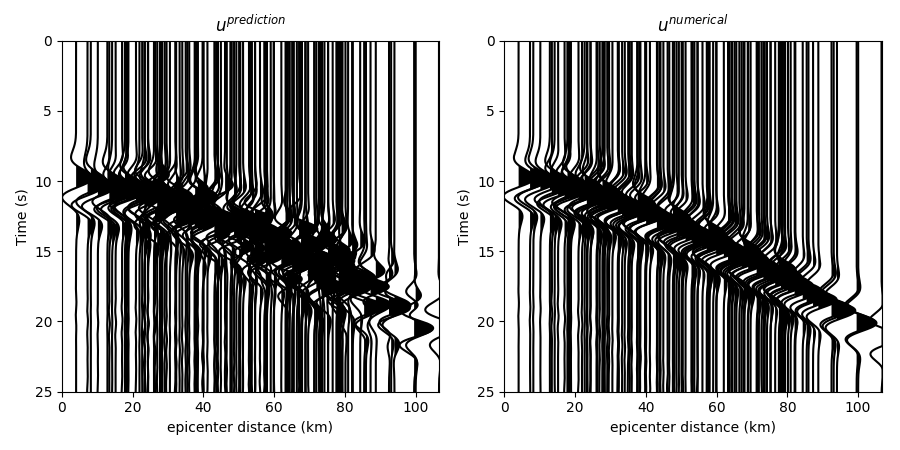

In [1134]:
# plot seismograms with distance 
from wiggle import *
plt.figure(figsize=(9,4.5))

rec1 = m[:,0,:].T
rec2 = uY_grid[:,:].T
timevector = np.linspace(-6.237575,25.,rec2[:,0].size)

plt.subplot(1,2,1)
wiggle(rec1, timevector, grid2src_distance, color='k')
plt.xlim(0,np.max(grid2src_distance))
plt.ylim(25,0)
plt.xlabel('epicenter distance (km)')
plt.ylabel('Time (s)')
plt.title('$u^{prediction}$')

plt.subplot(1,2,2)
wiggle(rec2, timevector, grid2src_distance, color='k')
plt.xlim(0,np.max(grid2src_distance))
plt.ylim(25,0)
plt.xlabel('epicenter distance (km)')
plt.ylabel('Time (s)')
plt.title('$u^{numerical}$')

plt.tight_layout()
plt.show()

- The quality of the estimation of $m$ (the displacement and the spatial gradients) depends on locations of the stations relative to the grid point.
- The quality of the estimation of $m$ improves as the number of stations used increases
- However, the use of more distant stations may under-estimate of the spatial derivatives of the waves, therefore we used only stations with closest possible distance with smoothly decreasing weighting factor.

The coefficients $A_i(x)$ and $B_i(x)$ are estimated by the least-squares method ($i=x,y$). Because it is simple 2-parameter estimation, it has the following analytic solution:

$$
A_i(x) = \frac{(v_t.v_t)(\partial_i u_t.u_t)-(u_t.v_t)(\partial_i u_t.v_t)}{(u_t.u_t)(v_t.v_t)-(u_t.v_t)^2}
$$
$$
B_i(x) = \frac{(u_t.u_t)(\partial_i u_t.v_t)-(u_t.v_t)(\partial_i u_t.u_t)}{(u_t.u_t)(v_t.v_t)-(u_t.v_t)^2}
$$

In [ ]:
# compute velocity

In [ ]:
# solving for A and B coefficients 